In [1]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e5, recombination_rate=1e-8, random_seed=40)

In [3]:
ts.num_trees

10

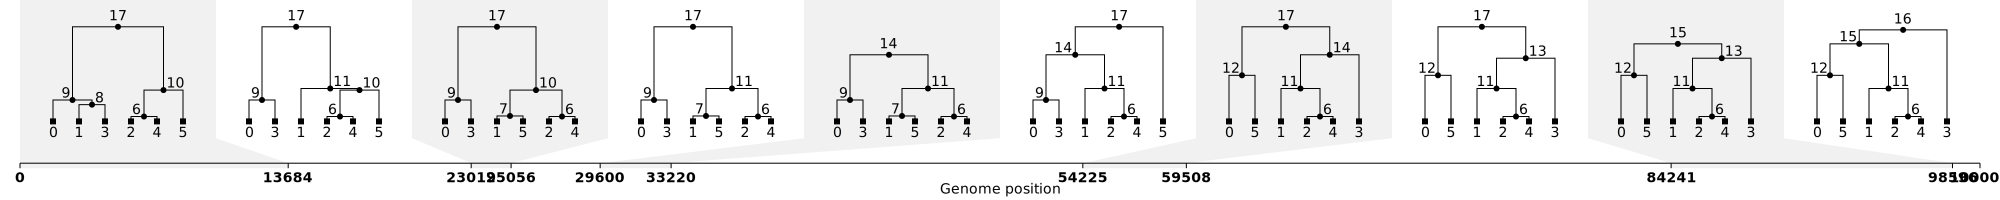

In [4]:
SVG(ts.draw_svg())

In [52]:
# from https://github.com/tskit-dev/tskit/issues/2118

def mirror_coordinates(ts):
    """
    Returns a copy of the specified tables in which all
    coordinates x are transformed into L - x.
    """
    L = ts.sequence_length
    tables = ts.dump_tables()
    left = tables.edges.left
    right = tables.edges.right
    tables.edges.left = L - right
    tables.edges.right = L - left
    tables.sites.position = L - tables.sites.position - 1
    tables.sort()
    return tables.tree_sequence()

def forward_extend(ts, verbose=False):
    edgediffs = ts.edge_diffs()
    trees1 = ts.trees()
    trees2 = ts.trees()
    _ = next(trees1)
    _ = next(edgediffs)


    t = ts.tables
    edges = t.edges
    new_left = edges.left
    new_right = edges.right

    pending_out = []
    pending_in = []
    # note we skip the first tree
    for (interval, edges_out, edges_in) in edgediffs:
        edges_out.extend(pending_out)
        edges_in.extend(pending_in)
        pending_out = []
        pending_in = []
        extended = [False for _ in edges_out]
        for j1, e1 in enumerate(edges_out):
            if not extended[j1]:
                for j2, e2 in enumerate(edges_out):
                    if not extended[j2]:
                        if e1.parent == e2.child:
                            for e_in in edges_in:
                                if e_in.right > interval.left:
                                    # assert next_tree.parent(e_in.child) == e_in.parent
                                    if e1.child == e_in.child and e2.parent == e_in.parent:
                                        # print("     ", interval, e1.child, "-", e1.parent, "-", e2.parent, " -> ", e_in)
                                        if verbose:
                                            print("ping!!", e1.id, "+", e2.id, "=", e_in.id)
                                        # extend e1 and e2, postpone e_in
                                        extended[j1] = True
                                        extended[j2] = True
                                        pending_out.extend([e1, e2])
                                        pending_in.append(e_in)
                                        new_right[e1.id] = interval.right
                                        new_right[e2.id] = interval.right
                                        new_left[e_in.id] = interval.right
                                        # TODO fix up this terrible flow control 
                                        # to make sure that the same edges aren't extended more than once
    keep = new_left < new_right
    edges.set_columns(
        left=new_left[keep],
        right=new_right[keep],
        parent=edges.parent[keep],
        child=edges.child[keep])
    return t.tree_sequence()
    
def extend_edges(ts, max_iter=100, verbose=False):
    num_edges = [ts.num_edges]
    for _ in range(max_iter):
        ts = forward_extend(ts, verbose=verbose)
        ts = mirror_coordinates(ts)
        ts = forward_extend(ts, verbose=verbose)
        ts = mirror_coordinates(ts)
        if ts.num_edges == num_edges[-1]:
            break
        else:
            num_edges.append(ts.num_edges)
    return ts, num_edges

ping!! 8 + 14 = 11
ping!! 6 + 12 = 10
ping!! 9 + 13 = 11
ping!! 6 + 12 = 10
[23, 20]


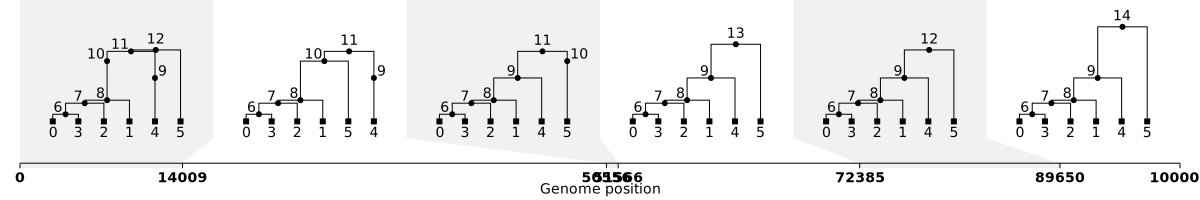

In [45]:
new_ts, num_edges = extend_edges(ts, verbose=True)
print(num_edges)
SVG(new_ts.draw_svg())

In [48]:
def verify_extending(ts):
    ets, num_edges = extend_edges(ts)
    sts = ets.simplify()
    sts.tables.assert_equals(ts.tables, ignore_provenance=True)
    print(num_edges)
    
verify_extending(ts)

[23, 20]


In [50]:
for seed in range(1, 100):
    # print("----", seed)
    ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e5, recombination_rate=1e-8, random_seed=seed)
    verify_extending(ts)

[22, 20]
[25, 19]
[22]
[46, 39, 38]
[33, 30, 28]
[40, 34]
[32, 31]
[28, 23]
[22, 20]
[33, 30, 28]
[17, 15]
[44, 37]
[47, 36, 34]
[62, 50]
[39, 35]
[36, 31, 29]
[21, 18]
[16]
[37, 30]
[35, 29, 28]
[28, 24, 23]
[28, 24]
[37, 29, 26]
[23, 20, 18]
[21, 19]
[38, 31]
[14, 12]
[38, 34]
[44, 36]
[36, 32]
[36, 30]
[22, 20]
[32, 27, 26]
[16]
[42, 36]
[19, 17]
[20, 18]
[24, 20]
[31, 29]
[38, 31, 29]
[45, 38, 37]
[28, 24]
[19, 16]
[22, 20]
[23, 21]
[25, 21]
[26, 24]
[47, 42]
[20]
[34, 28, 27]
[23, 21]
[34, 31]
[68, 53, 50]
[37, 31, 29]
[36, 30, 28, 27]
[25, 20]
[20, 16]
[31, 26]
[36, 27, 26]
[18, 16]
[14]
[26, 23, 22]
[15]
[27, 20]
[40, 29]
[40, 35, 33, 32]
[28, 22, 21]
[50, 42]
[21, 17]
[20, 17]
[58, 51]
[41, 35]
[21, 20]
[32, 30]
[22, 18]
[18, 16]
[20, 18]
[40, 35, 33]
[19, 16]
[30, 25, 24]
[19, 17, 16]
[28, 26]
[27, 24, 22, 20]
[26, 24]
[33, 27]
[28, 24]
[40, 34, 33]
[32, 29]
[34, 27]
[41, 32]
[45, 37, 35]
[23, 20]
[14]
[33, 30, 28]
[21, 18]
[28, 26]
[12]
[28, 24]
[23, 20]


In [60]:
ts = msprime.sim_ancestry(
        1000, 
        population_size=1000,
        sequence_length=1e7,
        recombination_rate=1e-8,
)
ets, num_edges = extend_edges(ts)
print(num_edges)

[15242, 12084, 11057, 10811, 10751, 10740, 10736]


In [72]:
Svals = [100, 1000, 10000]
Lvals = np.linspace(1e4, 3e6, 31)
num_edge_lists = {}
for S in Svals:
    nel = []
    for L in Lvals:
        ts = msprime.sim_ancestry(
            1000, 
            population_size=1000,
            sequence_length=int(L),
            recombination_rate=1e-8,
        )
        ets, num_edges = extend_edges(ts)
        nel.append(num_edges)
    num_edge_lists[S] = nel

LibraryError: Bad edges: contradictory children for a given parent over an interval

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

for S in Svals:
    reduction = [x[-1] / x[0] for x in num_edge_lists[S]]
    ax.plot(Lvals, reduction, label=f"num samples = {S}")
ax.set_xlabel("sequence length")
ax.set_ylabel("percent of edges left")
ax.legend();

In [82]:
import time
ts = msprime.sim_ancestry(
        1000, 
        population_size=1000,
        sequence_length=1e6,
        recombination_rate=1e-8,
    )
ets, _ = extend_edges(ts)

before_time = time.time()
a = ts.Tajimas_D()
next_time = time.time()
b = ets.Tajimas_D()
after_time = time.time()

print(f"Before: {next_time - before_time}, after: {after_time - next_time}")

Before: 0.0006997585296630859, after: 0.0005362033843994141
